<a href="https://colab.research.google.com/github/codes-by-pinewood/SeminarAdvancesInDL/blob/main/geodesic_transform_Sherry_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy==1.24.3
print(f"NumPy Version: {numpy.__version__}")
print(f"PyTorch Version: {torch.__version__}")

NameError: name 'numpy' is not defined

In [1]:
import numpy as np


In [14]:
!pip install nibabel
!pip install SimpleITK
!pip install monai
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
# ONLY 20 SAMPLES

root_dir = "/content/drive/My Drive/BRATS/MICCAI_BraTS2020_TrainingData"

os.chdir(root_dir)

!ls


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BraTS20_Training_001		  BraTS20_Training_012_pred.nii
BraTS20_Training_001_transformed  BraTS20_Training_012_transformed
BraTS20_Training_002		  BraTS20_Training_013
BraTS20_Training_002_transformed  BraTS20_Training_013_pred.nii
BraTS20_Training_003		  BraTS20_Training_013_transformed
BraTS20_Training_003_transformed  BraTS20_Training_014
BraTS20_Training_004		  BraTS20_Training_014_pred.nii
BraTS20_Training_004_transformed  BraTS20_Training_014_transformed
BraTS20_Training_005		  BraTS20_Training_015
BraTS20_Training_005_transformed  BraTS20_Training_015_transformed
BraTS20_Training_006		  BraTS20_Training_016
BraTS20_Training_006_transformed  BraTS20_Training_016_transformed
BraTS20_Training_007		  BraTS20_Training_017
BraTS20_Training_007_transformed  BraTS20_Training_017_transformed
BraTS20_Training_008		  BraTS20_Training_018
BraTS20_Training_008_transf

## Geodesic Transform

In [8]:
def merge_seg(seg_path):
    seg, _ = get_data(seg_path, is_seg=True)
    combined_seg = [(seg == 1) | (seg == 4), (seg == 1) | (seg == 4) | (seg == 2), seg == 4]
    combined_seg = np.stack(combined_seg, axis=0)
    return combined_seg

def get_data(input_name, is_seg=False):

    if not os.path.isfile(input_name):
        print("File not exists:", input_name)
        return -1

    img = sitk.ReadImage(input_name)
    np_img = sitk.GetArrayFromImage(img)
    spacing_raw = img.GetSpacing()
    if is_seg:
        return np.asarray(np_img, np.uint8), spacing_raw
    else:
        return np.asarray(np_img, np.float32), spacing_raw


In [9]:
import torch
import nibabel as nib
import numpy as np
from pathlib import Path
import os


def transform_geo_dist(dist, gt, label_name):
    margin = 0.5

    def _transform_layer(dist_layer, gt_layer):
        fg = (gt_layer == 1)
        bg = (gt_layer == 0)
        dist_layer[fg] = torch.clamp_min(dist_layer[fg], 0.0)
        dist_layer[bg] = torch.clamp_max(dist_layer[bg], 0.0)

        if torch.sum(fg) == 0:
            return torch.full_like(dist_layer, -1)

        fg_max = dist_layer[fg].max()
        dist_layer[bg] = torch.clamp_min(dist_layer[bg], -fg_max)

        dist_layer = dist_layer / (fg_max + 1e-8)

        if label_name == "fast_sgc_margin":
            dist_layer[fg] = dist_layer[fg] * (1.0 - margin) + margin
            dist_layer[bg] = dist_layer[bg] * (1.0 - margin) - margin

        dist_layer = torch.clamp(dist_layer, -1.0, 1.0)

        if label_name == "fast_sgc_clamp":
            dist_layer[(gt_layer > 0) & (dist_layer <= 0)] = dist_layer[dist_layer > 0.0001].min()
            dist_layer[(gt_layer == 0) & (dist_layer >= 0)] = dist_layer[dist_layer < -0.0001].max()

        return dist_layer

    for i in range(dist.shape[-1]):
        dist[..., i] = _transform_layer(dist[..., i], gt[..., i])
    return dist


def transform_gd_dist(dist, gt):
    def _transform_gd_dist_layer(dist_layer, gt_layer):
        # Ensure the shapes match and masks are boolean
        fg = (gt_layer == 1)
        bg = (gt_layer == 0)

        dist_layer[fg] = torch.clamp_min(dist_layer[fg], 0.52)
        dist_layer[bg] = torch.clamp_max(dist_layer[bg], 0.48)

        return dist_layer

    gt = gt[..., 0]
    print(f"gt.shape: {gt.shape}")


    for index in range(dist.shape[-1]):
        dist_layer = dist[..., index]
        gt_layer = gt[..., index]

        print("dist_layer shape:", dist_layer.shape)
        print("gt_layer shape:", gt_layer.shape)

        # Apply per-layer transformation
        dist[..., index] = _transform_gd_dist_layer(dist_layer, gt_layer)

    # Sanity check after processing
    assert not torch.any(torch.isnan(dist)), "NaNs introduced during transformation"

    return dist



def process_single_image(image_path, gt_path, output_path, label_name="fast_sgc_margin", dataset="BRATS", device="cpu"):
    print(f"Processing {image_path.name}")
    hard_gt_path = gt_path

    if dataset == "BRATS":
        hard_gt = np.transpose(merge_seg(hard_gt_path), [3, 2, 1, 0])

    else:
        hard_gt = get_data(gt_path, is_seg=True)[0]
        hard_gt = np.transpose(np.expand_dims(hard_gt, 0), [3, 2, 1, 0])

    hard_gt = torch.tensor(hard_gt, device=device)
    raw_geo = nib.load(image_path).get_fdata()
    geo_tensor = torch.tensor(raw_geo, device=device)

    if label_name == "gd_normed":
        transformed = transform_gd_dist(geo_tensor, hard_gt)
        print(f"transformed: {transformed}")
    else:
        transformed = transform_geo_dist(geo_tensor, hard_gt, label_name)

    result_np = transformed.cpu().numpy()
    print(f"RESULTS_NP: {result_np}")
    #result_np = np.transpose(result_np, [3, 2, 1, 0])
    print(f"output_path : {output_path}")
    os.makedirs(output_path.parent, exist_ok=True)
    nib.save(nib.Nifti1Image(result_np, affine=np.eye(4)), output_path)
    print(f"Saved to {output_path}")


In [7]:
import os
from pathlib import Path
import nibabel as nib
import numpy as np
from skimage.morphology import reconstruction  # Geodesic transform
import shutil

def geodesic_transform(image_array):
    # Normalize image between 0 and 1
    image_array = (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array))

    # Use image itself as both marker and mask for demonstration
    marker = np.copy(image_array)
    marker[1:-1, 1:-1, 1:-1] = 0  # Zero out the center to force geodesic propagation

    transformed = reconstruction(marker, image_array, method='dilation')
    return transformed

def process_sample(sample_dir):
    sample_path = Path(sample_dir)
    sample_name = sample_path.name
    output_dir = sample_path.parent / f"{sample_name}_transformed"
    output_dir.mkdir(exist_ok=True)

    image_files = [f for f in sample_path.glob("*.nii*") if "seg" not in f.stem]

    for img_file in image_files:
        print(f"Processing {img_file.name}...")

        # Load
        img = nib.load(str(img_file))
        img_data = img.get_fdata()

        # Apply geodesic transform
        transformed_data = geodesic_transform(img_data)

        # Save transformed image
        transformed_img = nib.Nifti1Image(transformed_data, affine=img.affine)
        save_path = output_dir / img_file.name
        nib.save(transformed_img, str(save_path))

    print(f"Saved transformed images in: {output_dir}")

# Example usage:
sample_dir = "/content/drive/My Drive/BRATS/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001"
process_sample(sample_dir)


ModuleNotFoundError: No module named 'numpy.rec'

In [ ]:
def process_sample(sample_dir):
    sample_path = Path(sample_dir)
    sample_name = sample_path.name
    output_dir = sample_path.parent / f"{sample_name}_transformed"
    output_dir.mkdir(exist_ok=True)

    image_files = [f for f in sample_path.glob("*.nii*") if "seg" in f.stem]

    for img_file in image_files:
        print(f"Processing {img_file.name} in {sample_name}...")
        img = nib.load(str(img_file))
        img_data = img.get_fdata()
        transformed_data = geodesic_transform(img_data)
        transformed_img = nib.Nifti1Image(transformed_data, affine=img.affine)
        save_path = output_dir / img_file.name
        nib.save(transformed_img, str(save_path))

    print(f"Saved transformed images in: {output_dir}")

# 🔥 Batch processing: loop through all samples
base_dir = "/content/drive/My Drive/BRATS/MICCAI_BraTS2020_TrainingData"
base_path = Path(base_dir)

# Loop over all folders starting with BraTS20_Training_
for sample_folder in base_path.glob("BraTS20_Training_*"):
    if sample_folder.is_dir():
        process_sample(sample_folder)

Processing BraTS20_Training_020_seg.nii in BraTS20_Training_020...
Saved transformed images in: /content/drive/My Drive/BRATS/MICCAI_BraTS2020_TrainingData/BraTS20_Training_020_transformed
Processing BraTS20_Training_003_seg.nii in BraTS20_Training_003...
Saved transformed images in: /content/drive/My Drive/BRATS/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003_transformed
Processing BraTS20_Training_010_seg.nii in BraTS20_Training_010...
Saved transformed images in: /content/drive/My Drive/BRATS/MICCAI_BraTS2020_TrainingData/BraTS20_Training_010_transformed
Processing BraTS20_Training_009_seg.nii in BraTS20_Training_009...
Saved transformed images in: /content/drive/My Drive/BRATS/MICCAI_BraTS2020_TrainingData/BraTS20_Training_009_transformed
Processing BraTS20_Training_007_seg.nii in BraTS20_Training_007...
Saved transformed images in: /content/drive/My Drive/BRATS/MICCAI_BraTS2020_TrainingData/BraTS20_Training_007_transformed
Processing BraTS20_Training_008_seg.nii in BraTS20_Trai

<ipython-input-11-346a07cee52d>:10: RuntimeWarning: invalid value encountered in divide
  image_array = (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array))


## Splitting Dataset

In [1]:
#Splitting into different subsets: train, test, val
import os
import random
import shutil
from pathlib import Path

def split_dataset(root_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """Splits the dataset into training, validation, and test sets.

    Args:
        root_dir: The root directory of the dataset.
        train_ratio: The proportion of the dataset to include in the training split.
        val_ratio: The proportion of the dataset to include in the validation split.
        test_ratio: The proportion of the dataset to include in the test split.
    """

    if train_ratio + val_ratio + test_ratio != 1.0:
        raise ValueError("The sum of train_ratio, val_ratio, and test_ratio must be 1.0")

    cases = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    random.shuffle(cases)  # Shuffle cases for randomness

    num_cases = len(cases)
    num_train = int(num_cases * train_ratio)
    num_val = int(num_cases * val_ratio)
    num_test = num_cases - num_train - num_val  # Ensure all cases are used

    train_cases = cases[:num_train]
    val_cases = cases[num_train:num_train + num_val]
    test_cases = cases[num_train + num_val:]

    splits = {"train": train_cases, "val": val_cases, "test": test_cases}

    for split_name, case_list in splits.items():
        output_dir = Path(root_dir) / split_name
        output_dir.mkdir(exist_ok=True)
        for case_name in case_list:
            source_dir = Path(root_dir) / case_name
            destination_dir = output_dir / case_name
            shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)
            print(f"Moved {case_name} to {destination_dir}")

if __name__ == "__main__":
    root_dir = "/content/drive/My Drive/BRATS/MICCAI_BraTS2020_TrainingData" #Replace with the actual path
    split_dataset(root_dir)


Moved BraTS20_Training_013_transformed_transformed to /content/drive/My Drive/BRATS/MICCAI_BraTS2020_TrainingData/train/BraTS20_Training_013_transformed_transformed
Moved BraTS20_Training_019 to /content/drive/My Drive/BRATS/MICCAI_BraTS2020_TrainingData/train/BraTS20_Training_019
Moved BraTS20_Training_005 to /content/drive/My Drive/BRATS/MICCAI_BraTS2020_TrainingData/train/BraTS20_Training_005
Moved BraTS20_Training_014_transformed to /content/drive/My Drive/BRATS/MICCAI_BraTS2020_TrainingData/train/BraTS20_Training_014_transformed
Moved BraTS20_Training_003 to /content/drive/My Drive/BRATS/MICCAI_BraTS2020_TrainingData/train/BraTS20_Training_003
Moved BraTS20_Training_015_transformed to /content/drive/My Drive/BRATS/MICCAI_BraTS2020_TrainingData/train/BraTS20_Training_015_transformed
Moved BraTS20_Training_020 to /content/drive/My Drive/BRATS/MICCAI_BraTS2020_TrainingData/train/BraTS20_Training_020
Moved BraTS20_Training_016_transformed to /content/drive/My Drive/BRATS/MICCAI_BraTS2

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import nibabel as nib
import os

# 1. Load Nifti
def load_nifti(file_path):
    img = nib.load(file_path)
    return img.get_fdata()

# 2. Model
class EOFormerModel(nn.Module):
    def __init__(self, num_classes=2):
        super(EOFormerModel, self).__init__()
        self.conv1 = nn.Conv3d(4, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(32, num_classes, kernel_size=1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv3(x)
        return x  # Output shape: [B, num_classes, D, H, W]

# 3. Get Input Tensor
def get_input_tensor(sample_dir, sample_num):
    t1 = load_nifti(os.path.join(sample_dir, f"{sample_num}_t1.nii"))
    t1ce = load_nifti(os.path.join(sample_dir, f"{sample_num}_t1ce.nii"))
    t2 = load_nifti(os.path.join(sample_dir, f"{sample_num}_t2.nii"))
    flair = load_nifti(os.path.join(sample_dir, f"{sample_num}_flair.nii"))

    input_np = np.stack([t1, t1ce, t2, flair], axis=0)
    input_np = (input_np - input_np.mean(axis=(1,2,3), keepdims=True)) / (input_np.std(axis=(1,2,3), keepdims=True) + 1e-8)
    input_tensor = torch.from_numpy(input_np).float().unsqueeze(0)  # [1, 4, 240, 240, 155]
    return input_tensor

# 4. Get GT Mask
def get_ground_truth(sample_dir, sample_num):
    seg = load_nifti(os.path.join(sample_dir, f"{sample_num}_seg.nii"))
    seg = np.clip(seg, 0, 1)
    gt_tensor = torch.from_numpy(seg).long().unsqueeze(0).unsqueeze(0)  # [1, 1, 240, 240, 155]
    return gt_tensor

# 5. Dice Loss (Multi-class)
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        num_classes = logits.shape[1]
        #print(f"num_classes: {num_classes}")
        probs = torch.softmax(logits, dim=1)
        targets_onehot = torch.nn.functional.one_hot(targets.squeeze(1), num_classes).permute(0, 4, 1, 2, 3).float()
        dims = (0,2,3,4)
        intersection = torch.sum(probs * targets_onehot, dims)
        cardinality = torch.sum(probs + targets_onehot, dims)
        dice_score = (2. * intersection + self.smooth) / (cardinality + self.smooth)
        return 1 - dice_score.mean()

# 6. Training
model = EOFormerModel(num_classes=2)
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_samples = [f"BraTS20_Training_{i:03d}" for i in range(1, 10)]  # Example: 001 to 010
sample_root_dir = "/content/drive/My Drive/BRATS/MICCAI_BraTS2020_TrainingData"

for epoch in range(5):
    model.train()
    total_loss = 0
    for sample_num in train_samples:
        sample_dir = os.path.join(sample_root_dir, sample_num)

        input_tensor = get_input_tensor(sample_dir, sample_num)
        gt_mask = get_ground_truth(sample_dir, sample_num)

        output = model(input_tensor)  # [1, 2, 240, 240, 155]
        loss = criterion(output, gt_mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_samples):.4f}")


def save_prediction_as_nifti(pred_tensor, reference_nii_path, save_path):
    # Remove batch dimension and convert to numpy
    pred_np = pred_tensor.squeeze(0).cpu().numpy().astype(np.uint8)

    # Load the affine from reference image
    reference_img = nib.load(reference_nii_path)
    affine = reference_img.affine

    # Save as .nii
    pred_nifti = nib.Nifti1Image(pred_np, affine)
    nib.save(pred_nifti, save_path)





In [12]:
preds = []
outputs = []
inputs = []
# 7. Testing + Prediction
test_samples = [f"BraTS20_Training_{i:03d}" for i in range(12, 18)]  # Test on 011, 012
model.eval()
with torch.no_grad():
    for sample_num in test_samples:
        sample_dir = os.path.join(sample_root_dir, sample_num)

        input_tensor = get_input_tensor(sample_dir, sample_num)
        output = model(input_tensor)
        inputs.append(input_tensor)

        outputs.append(output)
        pred = torch.argmax(torch.softmax(output, dim=1), dim=1)  # [1, 240, 240, 155]
        preds.append(pred)
        reference_img_path = os.path.join(sample_dir, f"{sample_num}_seg.nii")  # Any modality works
        output_dir = "/content/drive/My Drive/BRATS/MICCAI_BraTS2020_TrainingData"
        save_path = os.path.join(output_dir, f"{sample_num}_pred.nii")
        save_prediction_as_nifti(pred, reference_img_path, save_path)

        print(f"Saved prediction for {sample_num} to {save_path}")

        print(f"Prediction shape for {sample_num}: {pred.shape}")

NameError: name 'model' is not defined

In [1]:
def save_prediction_as_nifti(pred_tensor, reference_nii_path, save_path):
    # Remove batch dimension and convert to numpy
    pred_np = pred_tensor.squeeze(0).cpu().numpy().astype(np.uint8)  # Shape: (240, 240, 155)

    # Load the affine from reference image (e.g., one of the modalities)
    reference_img = nib.load(reference_nii_path)
    affine = reference_img.affine

    # Save as .nii
    pred_nifti = nib.Nifti1Image(pred_np, affine)
    nib.save(pred_nifti, save_path)

In [ ]:
import matplotlib.pyplot as plt


# 2. Get Input Tensor
def get_input_tensor(formatted_sample_num, sample_dir, sample_num):
    print(f"sample_dir: {sample_dir}")
    print(f"sample_num: {sample_num}")

    t1 = load_nifti(os.path.join(sample_dir, f"{formatted_sample_num}_t1.nii"))
    t1ce = load_nifti(os.path.join(sample_dir, f"{formatted_sample_num}_t1ce.nii"))
    t2 = load_nifti(os.path.join(sample_dir, f"{formatted_sample_num}_t2.nii"))
    flair = load_nifti(os.path.join(sample_dir, f"{formatted_sample_num}_flair.nii"))

    input_np = np.stack([t1, t1ce, t2, flair], axis=0)
    input_np = (input_np - input_np.mean(axis=(1, 2, 3), keepdims=True)) / (input_np.std(axis=(1, 2, 3), keepdims=True) + 1e-8)
    input_tensor = torch.from_numpy(input_np).float().unsqueeze(0)  # [1, 4, D, H, W]
    return input_tensor


def visualize_prediction(gt_mask, pred_mask, slice_idx=77):
    gt_np = gt_mask.squeeze().detach().cpu().numpy()     # May be (1, 240, 240, 155)
    pred_np = pred_mask.squeeze().detach().cpu().numpy() # Same

    # Make sure we now have (240, 240, 155)
    if gt_np.ndim == 4:
        gt_np = gt_np[0]
    if pred_np.ndim == 4:
        pred_np = pred_np[0]

    print("GT shape after squeeze:", gt_np.shape)
    print("Pred shape after squeeze:", pred_np.shape)

    # ✅ Now both are (240, 240, 155), so we can slice
    gt_slice = gt_np[0, :, slice_idx]  # 2D: (240, 240)
    pred_slice = pred_np[0, :, slice_idx]  # 2D: (240, 240)
    gt_slice = gt_np[:, :, slice_idx]       # shape: (240, 240)
    pred_slice = pred_np[:, :, slice_idx]
    print(gt_slice.shape)
    print(pred_slice.shape)
    # ✅ Now we can plot safely
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(gt_slice, cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pred_slice, cmap='gray')
    plt.title("Prediction")
    plt.axis('off')


# 3. Get Ground Truth Mask
def get_ground_truth(sample_dir, sample_num):
    seg = load_nifti(os.path.join(sample_dir, f"{sample_num}_seg.nii"))
    seg = np.clip(seg, 0, 1)  # Binarize the mask for binary segmentation
    gt_tensor = torch.from_numpy(seg).long().unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, D, H, W]
    return gt_tensor


# Main Code
sample_num = 2
formatted_sample_num = f"BraTS20_Training_{sample_num:03d}"
print(f"Formatted sample number: {formatted_sample_num}")

sample_dir = f"/content/drive/My Drive/BRATS/MICCAI_BraTS2020_TrainingData/{formatted_sample_num}"

# Get input tensor and ground truth mask
input_tensor = get_input_tensor(formatted_sample_num, sample_dir, sample_num)
gt_mask = get_ground_truth(sample_dir, formatted_sample_num)


#pred = gt_mask  # Replace with model output when available

# Visualize prediction and ground truth



here
GT shape after squeeze: (240, 240, 155)
Pred shape after squeeze: (240, 240, 155)
(240, 240)
(240, 240)
here
GT shape after squeeze: (240, 240, 155)
Pred shape after squeeze: (240, 240, 155)
(240, 240)
(240, 240)
here
GT shape after squeeze: (240, 240, 155)
Pred shape after squeeze: (240, 240, 155)
(240, 240)
(240, 240)


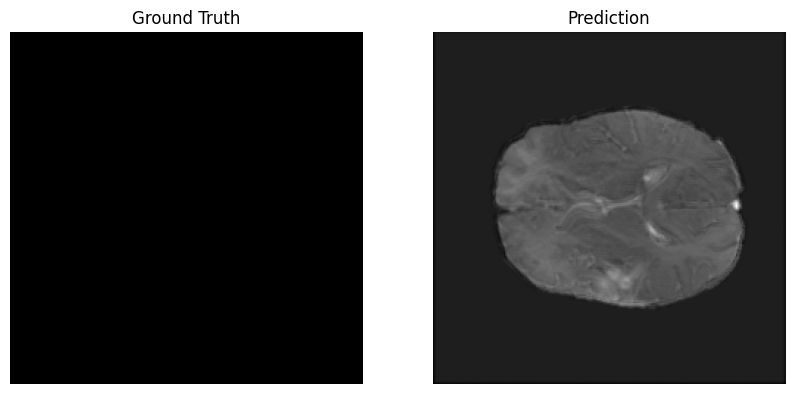

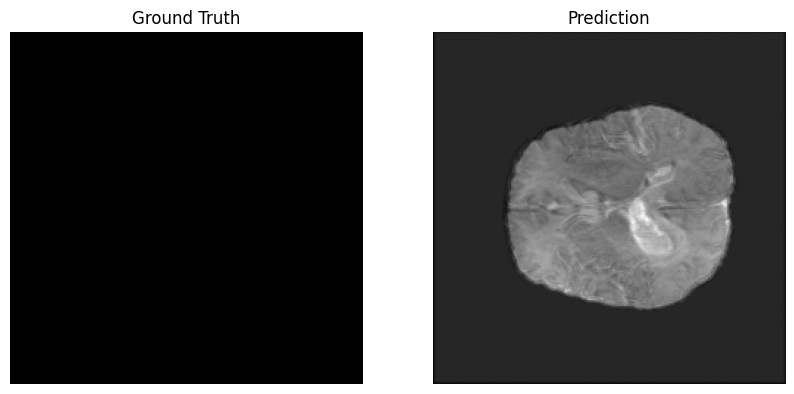

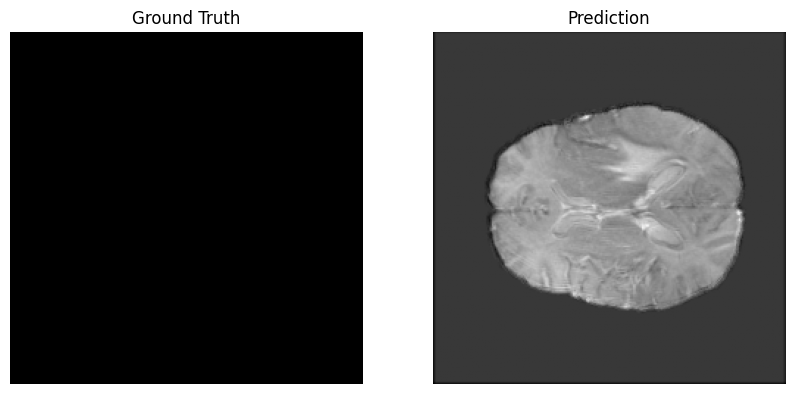

In [10]:
for i in range(len(outputs)):
  for j in range(len(preds)):
    if i == j:
      print("here")
      visualize_prediction(preds[j], outputs[i])


In [8]:
print(outputs)

[]


In [2]:
# prompt: display the .nii images

import matplotlib.pyplot as plt
import nibabel as nib

def display_nii(file_path, slice_idx=80):
    img = nib.load(file_path)
    data = img.get_fdata()
    plt.imshow(data[:, :, slice_idx], cmap='gray')
    plt.title(f"Slice {slice_idx} of {file_path}")
    plt.show()

# Example usage (replace with your file paths)
# Assuming you have saved predictions as .nii files
# Adjust slice_idx as needed

for sample_num in test_samples:
    prediction_path = os.path.join(output_dir, f"{sample_num}_pred.nii")
    display_nii(prediction_path)


NameError: name 'test_samples' is not defined

In [11]:
import os
base_dir = "/content/drive/My Drive/BRATS/MICCAI_BraTS2020_TrainingData"
test_samples = [f"BraTS20_Training_{i:03d}" for i in range(13, 14)]


for sample_num in test_samples:
    #sample_dir = os.path.join(base_dir, sample_num)
    sample_dir = base_dir
    prediction_path = os.path.join(sample_dir, f"{sample_num}_pred.nii")

    # Optionally check if the file exists
    if os.path.exists(prediction_path):
        display_nii(prediction_path)
    else:
        print(f"Prediction file not found for {sample_num} at {prediction_path}")


Prediction file not found for BraTS20_Training_013 at /content/drive/My Drive/BRATS/MICCAI_BraTS2020_TrainingData/BraTS20_Training_013_pred.nii
